# Start

In [1]:
import pandas as pd
import numpy as np
import re
import random
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import seaborn as sns
from tqdm import tqdm

from torch.utils.data import Dataset
import torch.optim as optim
from torch import nn
import torch

import warnings
warnings.filterwarnings("ignore")

In [2]:
seed=1
random.seed(seed)
os.environ['PYTHONHASHSEED']  = str(seed)
np.random.seed(seed)

In [3]:
# from google.colab import drive, files

# try:
#   drive.mount('/content/drive/data')

#   %cd /content/drive/My Drive
# except:
#   uploaded = files.upload()

In [4]:
from google.colab import files
uploaded = files.upload()

Saving Suicide_Detection_30000.csv to Suicide_Detection_30000.csv


In [5]:
from google.colab import drive
import os

# Check if Google Drive is already mounted
drive_mount_path = '/content/drive'
drive_folder_path = os.path.join(drive_mount_path, 'My Drive')

if not os.path.ismount(drive_mount_path):
    # Mount Google Drive because it is not already mounted
    drive.mount(drive_mount_path)

# Check if the directory exists
if os.path.exists(drive_folder_path):
    # Change the current working directory to "My Drive"
    %cd "$drive_folder_path"
else:
    print(f"The directory {drive_folder_path} does not exist.")

Mounted at /content/drive
/content/drive/My Drive


In [52]:
df = pd.read_csv('Suicide_Detection_30000.csv')

# EDA

In [53]:
df.head()

,id,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [54]:
texts = df['text']
texts

0        Ex Wife Threatening SuicideRecently I left my ...
1        Am I weird I don't get affected by compliments...
2        Finally 2020 is almost over... So I can never ...
3                i need helpjust help me im crying so hard
4        I’m so lostHello, my name is Adam (16) and I’v...
                               ...                        
29995    I don’t like getting old When I look at the ag...
29996    I’m not a fan of Prince. I just don’t like his...
29997    ignore me ranting lol i genuinely think there ...
29998    I might fail my last class needed to graduate ...
29999    Random Q&amp;A time!!!! Hi I’m some bisexual d...
Name: text, Length: 30000, dtype: object

In [55]:
import re

formatted_texts = texts.apply(lambda x: re.sub(r"(@\[A-Za-z0-9']+)|(\w+:\/\/\S+)|^rt|http.+?", "", x))
formatted_texts = [text.replace("'", " ") for text in formatted_texts]
formatted_texts = [text.replace("’", " ") for text in formatted_texts]
texts = [text.lower() for text in formatted_texts]
texts[:5]

['ex wife threatening suiciderecently i left my wife for good because she has cheated on me twice and lied to me so much that i have decided to refuse to go back to her. as of a few days ago, she began threatening suicide. i have tirelessly spent these paat few days talking her out of it and she keeps hesitating because she wants to believe i ll come back. i know a lot of people will threaten this in order to get their way, but what happens if she really does? what do i do and how am i supposed to handle her death on my hands? i still love my wife but i cannot deal with getting cheated on again and constantly feeling insecure. i m worried today may be the day she does it and i hope so much it doesn t happen.',
 'am i weird i don t get affected by compliments if it s coming from someone i know irl but i feel really good when internet strangers do it',
 'finally 2020 is almost over... so i can never hear "2020 has been a bad year" ever again. i swear to fucking god it s so annoying',
 'i

In [56]:
label_encoder = LabelEncoder()
df['encoded_class'] = label_encoder.fit_transform(df['class'])
labels = df['encoded_class']
labels

0        1
1        0
2        0
3        1
4        1
        ..
29995    0
29996    0
29997    0
29998    1
29999    0
Name: encoded_class, Length: 30000, dtype: int64

In [57]:
df.head()

,id,text,class,encoded_class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide,1
1,3,Am I weird I don't get affected by compliments...,non-suicide,0
2,4,Finally 2020 is almost over... So I can never ...,non-suicide,0
3,8,i need helpjust help me im crying so hard,suicide,1
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,1


In [58]:
df['encoded_class'].value_counts()

0    15063
1    14937
Name: encoded_class, dtype: int64

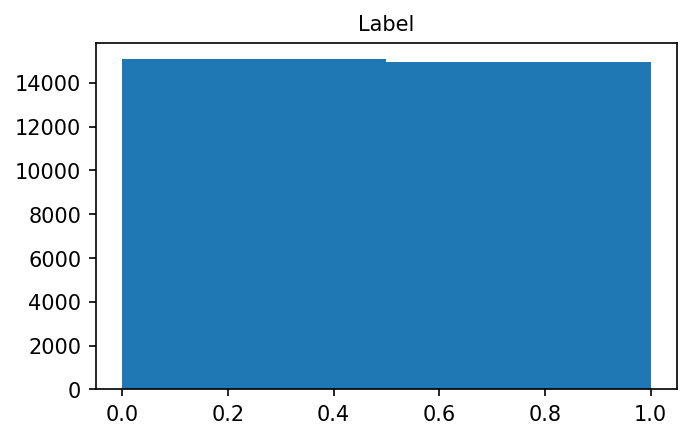

In [59]:
plt.figure(figsize=(5, 3), dpi=150)
plt.title("Label", fontsize=10)
plt.hist(df["encoded_class"], bins=2);

In [60]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [61]:
def remove_punctuation(tokenized_texts: list) -> list:
    filtered_texts = []
    for tokenized_text in tokenized_texts:
        filtered_texts.append([re.sub(r"[^0-9A-Za-z]", "", token) for token in tokenized_text if re.sub(r"[^0-9A-Za-z]", "", token).strip()])
    return filtered_texts

In [62]:
def clean_stopwords(tokenized_texts: list) -> list:
    filtered_texts = []
    for tokenized_text in tokenized_texts:
        filtered_texts.append([word for word in tokenized_text if word.lower() not in [*stop_words, 'im']])
    return filtered_texts

In [63]:
tokenized_texts = []
for text in texts:
  tokenized_texts.append(nltk.word_tokenize(text))

In [64]:
tokenized_texts = remove_punctuation(tokenized_texts)
tokenized_texts = clean_stopwords(tokenized_texts)

In [65]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [66]:
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()
lemmatized_texts_wo_punct = []
for clean_tokenized_text in tokenized_texts:
  lemmatized_texts_wo_punct.append([wnl.lemmatize(i,j[0].lower()) if j[0].lower() in ['a','n','v'] else wnl.lemmatize(i) for i,j in pos_tag(clean_tokenized_text)])

In [67]:
lemmatized_texts_wo_punct = clean_stopwords(lemmatized_texts_wo_punct)
lemmatized_texts_wo_punct = [' '.join(text) for text in lemmatized_texts_wo_punct]

In [68]:
!pip install -U sentence-transformers

In [69]:
from sentence_transformers import SentenceTransformer

model_st = SentenceTransformer('all-MiniLM-L6-v2')

In [70]:
X_train, X_test, y_train, y_test = train_test_split(lemmatized_texts_wo_punct, labels, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [71]:
print(f'len(X_train) = {len(X_train)}')
print(f'len(y_train) = {len(y_train)}')
print(f'len(X_val) = {len(X_val)}')
print(f'len(y_val) = {len(y_val)}')
print(f'len(X_test) = {len(X_test)}')
print(f'len(y_test) = {len(y_test)}')

len(X_train) = 18000
len(y_train) = 18000
len(X_val) = 6000
len(y_val) = 6000
len(X_test) = 6000
len(y_test) = 6000


In [72]:
X_train_emb = model_st.encode(X_train)
X_val_emb = model_st.encode(X_val)
X_test_emb = model_st.encode(X_test)

# Model

In [232]:
model = nn.Sequential(
    nn.Linear(X_train_emb.shape[1], 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 1),
    nn.Sigmoid()
).to("cpu")

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [233]:
class CustomDataset(Dataset):
    def __init__(self, input_df, target_df, transform=None):
        self.input_df = input_df
        self.target_df = target_df
        self.transform = transform

    def __len__(self):
        return len(self.input_df)

    def __getitem__(self, index):
        # Get the input and target data at the specified index
        input_tensor = torch.tensor(self.input_df[index], dtype=torch.float32)
        target_tensor = torch.tensor(self.target_df[index], dtype=torch.float32)
        return input_tensor, target_tensor

In [234]:
y_train_array = np.array(y_train)
y_test_array = np.array(y_test)
y_val_array = np.array(y_val)

In [235]:
train_dataloader = torch.utils.data.DataLoader(CustomDataset(X_train_emb, y_train_array), 64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(CustomDataset(X_val_emb, y_val_array), 64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(CustomDataset(X_test_emb, y_test_array), 1, shuffle=False)

In [236]:
# for epoch in range(10):
#     running_loss = 0.0
#     for i, (inputs, labels) in enumerate(train_loader):
#         # Zero the parameter gradients
#         optimizer.zero_grad()

#         # Forward pass and compute the loss
#         outputs = model(inputs.view(inputs.size(0), -1))
#         labels = labels.unsqueeze(1)
#         loss = criterion(outputs, labels)

#         # Backward pass and optimize the parameters
#         loss.backward()
#         optimizer.step()

#         # Print the statistics
#         running_loss += loss.item()
#         if i == len(train_loader) - 1:
#             print('epoch %d loss: %.3f' % (epoch+1, running_loss / 100))

In [237]:
def train_and_validate(model, criterion, optimizer, train_dataloader, val_dataloader, n_epochs):
    train_loss = []
    val_losses = []

    for epoch in range(n_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_dataloader):
            optimizer.zero_grad()
            outputs = model(inputs.view(inputs.size(0), -1))
            labels = labels.unsqueeze(1)
            # loss = criterion(outputs, labels.long())
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i == len(train_dataloader) - 1:
              train_epoch_loss = running_loss / len(train_dataloader)
              train_loss.append(train_epoch_loss)
              print('Epoch %d | Training loss: %.3f' % (epoch+1, train_epoch_loss))

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():  # If we make validation there is no need to track gradients
            for i, (inputs, labels) in enumerate(val_dataloader):
                outputs = model(inputs.view(inputs.size(0), -1))
                labels = labels.unsqueeze(1)
                val_loss = criterion(outputs, labels)
                running_val_loss += val_loss.item()
                if i == len(val_dataloader) - 1:
                  val_epoch_loss = running_val_loss / len(val_dataloader)
                  val_losses.append(val_epoch_loss)
                  print('Epoch %d | Validation loss: %.3f' % (epoch+1, val_epoch_loss))
                  print('--------------------------------')

    # Plotting training and validation loss
    plt.plot(range(1, len(train_loss)+1), train_loss, label='Training Loss')
    plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

Epoch 1 | Training loss: 0.321
Epoch 1 | Validation loss: 0.229
--------------------------------
Epoch 2 | Training loss: 0.215
Epoch 2 | Validation loss: 0.221
--------------------------------
Epoch 3 | Training loss: 0.202
Epoch 3 | Validation loss: 0.213
--------------------------------
Epoch 4 | Training loss: 0.196
Epoch 4 | Validation loss: 0.211
--------------------------------


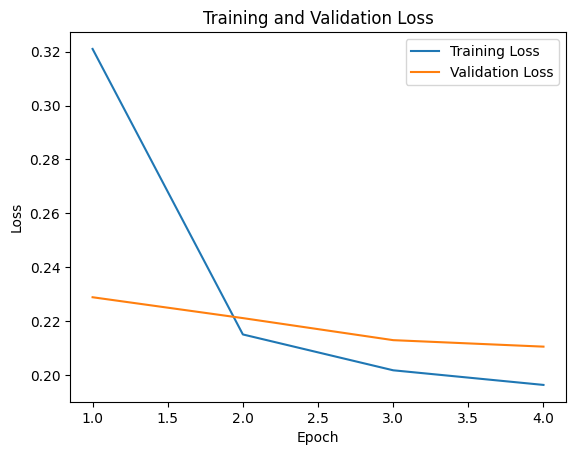

In [238]:
train_and_validate(model, criterion, optimizer, train_dataloader, val_dataloader, 4)

In [239]:
total_loss = 0
total_correct = 0
preds = []
with torch.no_grad():
    for inputs, targets in test_dataloader:
        output = model(inputs)
        if output >= 0.5:
          preds.append(1)
        else:
          preds.append(0)
len(preds)

6000

In [240]:
print(classification_report(y_test_array, preds))

              precision    recall  f1-score   support

           0       0.92      0.91      0.92      3002
           1       0.91      0.93      0.92      2998

    accuracy                           0.92      6000
   macro avg       0.92      0.92      0.92      6000
weighted avg       0.92      0.92      0.92      6000

